## 准备工作

In [42]:
import scipy.io as sio  # 从.mat文件中读取数据集
import numpy as np
from tqdm import tqdm
from differential_evolution.DifferentialEvolution import DifferentialEvolution
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  # SVC用于分类，SVR用于回归
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

### 实值映射到0-1

In [43]:
# 根据种群个体的编码值，获得要选择的实例的索引
def get_indices(x):
    x = x.astype(int)  # 数据范围在0-2之间，转化成int的同时会舍去小数部分，从而将个体映射到0-1编码
    indices = np.where(x == 1)  # 1代表选择该实例，返回值是tuple，tuple[0]取元组中的第一个元素
    return indices[0]


# 得到分类、以及分类所对应的索引
def get_class_index(y):
    # 统计每个类别的个数，y.max()+1是类别的个数
    num_class = y.max() + 1
    counts = np.zeros(num_class, dtype=int)
    classes = []
    for i in range(y.shape[0]):  # y.shape[0]相当于y的长度
        counts[y[i]] += 1
    for i in range(num_class):
        classes.append(
            np.where(y == i)[0])  # np.where() 返回值是一个tuple数组，np.where(y == i)[0],表示取出该tuple数组的第一个元素，是一个ndarray数组
    return num_class, classes, counts

### 获取实例子集

In [55]:
# 根据索引得到要选择的子集：数据和标签
# minimum的最大值不能超过数据集中包含的所有类别的最小数量
def get_sub_dataset(xi, indices, x, y, num_class, classes, minimum=10):
    # 根据索引得到实例子集
    lenth = len(indices)
    x_sub = x[indices, :]
    y_sub = y[indices]

    #print("实例子集x：", x_sub)
    #print("实例子集y：", y_sub)
    # 计算实例子集各个类别的数量
    counts_sub = np.zeros(num_class, dtype=int)
    for i in range(y_sub.shape[0]):
        counts_sub[y_sub[i]] += 1
    print("实例子集的数量：", counts_sub)
    # 遍历子集中各个类别的数量，保证大于最小数量
    for i in range(num_class):
        # 当实例个数小于minimum，随机添加实例达到最小限制
        if counts_sub[i] < minimum:
            # 转换成集合进行差运算（& | -，分别是交、并、差） unselected_indices是一个set集合
            unselected_indices_set = set(classes[i]) - set(indices)
            # list(unselected_indices)将集合转换成list
            unselected_indices = np.array(list(unselected_indices_set))
            # replace=False表示不允许重复
            random_selecte_indices = np.random.choice(unselected_indices, size=minimum - counts_sub[i], replace=False)

            # 添加后更改个体xi的参数
            for j in range(0, minimum - counts_sub[i]):  # 小于minimum时，添加实例时，需要同步更改xi个体的实值大小，由0-1的改为1-2
                xi[random_selecte_indices[j]] = np.random.rand() + 1  # np.random.rand()生成0-1的随机数
                index = np.searchsorted(indices, random_selecte_indices[j])
                indices = np.insert(indices, index, random_selecte_indices[j])
                x_sub = np.insert(x_sub, index, x[random_selecte_indices[j], :], axis=0)
                y_sub = np.insert(y_sub, index, y[random_selecte_indices[j]])
                
            print(f"类别{i}所要补充的个体数为{minimum - counts_sub[i]},索引为：", random_selecte_indices)
            #random_selecte_x = x[random_selecte_indices, :]
            #random_selecte_y = y[random_selecte_indices]
            # 注意以下是将添加的实例拼接到原来实例子集的后面，这个和新的个体xi并非一一对应，因为模型训练时，划分数据集，会把实例顺序打乱，（若想保持一致，后面可以再进行优化）
            #x_sub = np.concatenate((x_sub, random_selecte_x))  # 将子集拼接在一起 concatenate默认axis=0
            #y_sub = np.concatenate((y_sub, random_selecte_y))  # 将子集拼接在一起 concatenate默认axis=0
    print("最终的索引为：",indices)
    return x_sub, y_sub, xi

### 适应度函数

In [45]:
# 适应度函数/目标函数
def objective_function(xi, dataset_x, dataset_y, model, minimum):
    # 先将x的实值编码四舍五入得到0-1编码，根据编码得到训练子集
    indices = get_indices(xi)
    num_class, classes, counts = get_class_index(dataset_y)
    x_sub, y_sub, xi = get_sub_dataset(xi, indices, dataset_x, dataset_y, num_class, classes, minimum=minimum)

    # 模型训练
    x_train, x_test, y_train, y_test = train_test_split(x_sub, y_sub, test_size=0.3, random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # 计算准确率
    accuracy = accuracy_score(y_test, y_pred)

    # 计算错误率
    error_rate = 1 - accuracy
    return error_rate


# 求适应度
def fitness(x, model, dataset_x, dataset_y, minimum=0):
    result = np.empty(x.shape[0])  # 记录种群中个体的适应度
    # 计算每个个体的适应度
    for i in range(0, x.shape[0]):
        result[i] = objective_function(x[i, :], dataset_x, dataset_y, model, minimum)
    return result

## 训练阶段

### 加载数据集

In [34]:
# 读取.mat文件
mat_data = sio.loadmat('../data/dataset/CNS.mat')
#print(mat_data.keys())
# 提取变量
dataset_x = mat_data['X']
dataset_y = mat_data['Y']
dataset_y = dataset_y[:, 0]
# 显示变量信息
print("x的形状:", dataset_x.shape)
print("y的数据类型:", dataset_y.shape)
# 统计每个类别的个数，y.max()+1是类别的个数
counts = np.zeros(dataset_y.max() + 1)
for i in range(dataset_y.shape[0]):
    counts[dataset_y[i]] += 1
print("每种类别的数量：", counts)

x的形状: (60, 7129)
y的数据类型: (60,)
每种类别的数量： [39. 21.]


### 参数设定

In [46]:
NP = 50  # 个体数目
D = dataset_y.shape[0]  # 目标函数中变量的个数
G = 100  # 最大迭代数
CR = 0.1  # 交叉算子
Threshold = 1e-6  # 阈值
F = 0.5  # 变异算子
Left = 0  # 左边界
Right = 2  # 右边界

# 初始化 SVM 分类器
# 通过管道将标准化操作和模型相连接
clf = make_pipeline(StandardScaler(), SVC(kernel='linear', cache_size=600))  # 'linear' 是线性核，也可以选择 'rbf', 'poly' 等核函数

In [39]:
x = np.random.rand(NP, D) * (Right - Left) + Left  # 在[Left,Right]之间产生随机数

# 记录进化迭代的过程
number_generations = G
per_generation_optimal_value = np.zeros(G)

x_fitness = fitness(x, clf, dataset_x, dataset_y, minimum=15)

de = DifferentialEvolution(NP, D, G, CR, Threshold, F, Left, Right)

with tqdm(total=G, desc="DE") as pbar:
    for i in range(0, G):
        #v=variation(x,F) # 变异
        v = de.variation_optimize(x)  # 变异的优化
        c = de.cross(x, v)  # 交叉

        c = de.boundary_process(c)  # 若超出边界则重新生成

        c_fitness = fitness(c, clf, dataset_x, dataset_y)  # 对新的试验种群求适应度
        for m in range(0, x.shape[0]):
            if c_fitness[m] < x_fitness[m]:  # 贪婪地选择当前最优个体
                x[m, :] = c[m, :]
                x_fitness[m] = c_fitness[m]
        index = np.argmin(x_fitness)  # 记录最优个体索引
        per_generation_optimal_value[i] = x_fitness[index]  # 记录最优适应度
        # 动态更新进度条信息
        pbar.set_postfix({
            "当前迭代次数": i + 1,
            "最优个体索引": index,
            "目标函数最小值": round(x_fitness[index], 3),
            "当前最高准确率": round(1 - x_fitness[index], 3)
        })
        # 更新进度条
        pbar.update(1)

DE: 100%|██████████| 100/100 [00:22<00:00,  4.49it/s, 当前迭代次数=100, 最优个体索引=13, 目标函数最小值=0, 当前最高准确率=1] 


### 绘图

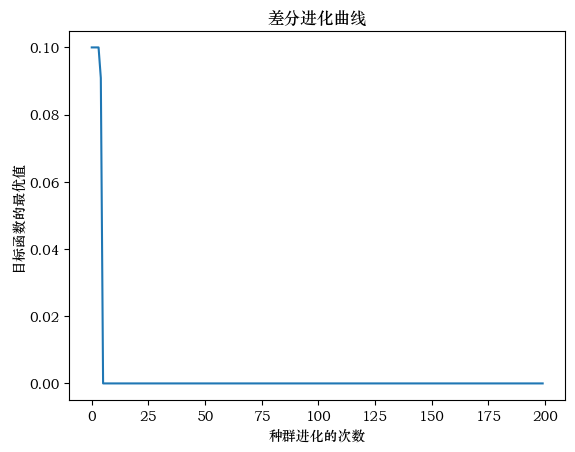

In [23]:
import matplotlib.pyplot as plt

# 设置可显示中文宋体
plt.rcParams['font.family'] = 'STZhongsong'
# 生成 x 轴数据：0 到 G，间隔为 1
x = np.arange(0, number_generations, 1)

# 生成 y 轴数据：每次迭代的最优值
y = per_generation_optimal_value

# 绘制折线图
plt.plot(x, y)

# 设置标题和坐标轴标签
plt.title("差分进化曲线")
plt.xlabel("种群进化的次数")
plt.ylabel("目标函数的最优值")

# 显示图形
plt.show()


## 测试

### 模型测试

### 虚拟数据测试

In [56]:
xx = np.array([
    [0.2, 1.2],
    [1.3, 2.4],
    [2.6, 3.5],
    [3.2, 4.2],
    [4.3, 5.4],
    [5.6, 6.5],
    [6.2, 7.2],
    [7.3, 8.4],
    [8.6, 9.5],
    [9.2, 10.2],
    [10.3, 2.4],
    [11.6, 3.5],
    [12.2, 2.2],
    [13.3, 2.4],
    [14.6, 3.5],
    [15.2, 2.2],
    [16.3, 2.4],
    [17.6, 3.5],
    [18.2, 2.2],
    [29.3, 2.4],
    [20.6, 3.5],
    [21.2, 2.2],
    [22.3, 2.4],
    [23.6, 3.5],

])

print(xx.shape)
yy = np.array([0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1])
print(yy.shape)
xi = np.random.rand(24) * (2 - 0) + 0

print("随机生成的个体：", xi)

indexes = get_indices(xi)

print("个体对应的实例索引：", indexes)

num_class, classes, counts = get_class_index(yy)

#print("类：",num_class)

#print("类的数量：",counts)

x_sub, y_sub, xii = get_sub_dataset(xi, indexes, xx, yy, num_class, classes, minimum=10)


print("新的xi：", xii)

print("选择的实例子集x：", x_sub)
print("选择的实例子集y：", y_sub)
print("Over")

(24, 2)
(24,)
随机生成的个体： [0.90134014 0.88009886 0.45257217 1.58299113 0.67355275 0.1644625
 0.30886476 1.08858189 0.60404185 0.0543694  0.54360698 1.47170449
 0.77957144 0.66145731 0.0763697  1.84130609 1.70566116 0.71581459
 0.94886273 0.17542914 1.17303374 1.00025512 0.9181145  1.54156634]
个体对应的实例索引： [ 3  7 11 15 16 20 21 23]
实例子集的数量： [5 3]
类别0所要补充的个体数为5,索引为： [22  9 18  0 17]
类别1所要补充的个体数为7,索引为： [19  5 10  8 12  2  4]
最终的索引为： [ 0  2  3  4  5  7  8  9 10 11 12 15 16 17 18 19 20 21 22 23]
新的xi： [1.21619668 0.88009886 1.79532356 1.58299113 1.64910349 1.06568058
 0.30886476 1.08858189 1.61371264 1.0307646  1.63763199 1.47170449
 1.92965503 0.66145731 0.0763697  1.84130609 1.70566116 1.95352154
 1.58862663 1.81372931 1.17303374 1.00025512 1.10022735 1.54156634]
选择的实例子集x： [[ 0.2  1.2]
 [ 2.6  3.5]
 [ 3.2  4.2]
 [ 4.3  5.4]
 [ 5.6  6.5]
 [ 7.3  8.4]
 [ 8.6  9.5]
 [ 9.2 10.2]
 [10.3  2.4]
 [11.6  3.5]
 [12.2  2.2]
 [15.2  2.2]
 [16.3  2.4]
 [17.6  3.5]
 [18.2  2.2]
 [29.3  2.4]
 [20.6  3.5]
 [2

In [41]:
import numpy as np

# 创建一个升序的一维数组
arr = np.array([1, 3, 5, 7, 9])

# 要插入的元素
value = 10

# 查找插入位置，保持升序
index = np.searchsorted(arr, value)
print("索引值：",index)
# 在指定位置插入元素
new_arr = np.insert(arr, index, value)

print(new_arr)


索引值： 5
[ 1  3  5  7  9 10]
